# Citations
'Machine Learning Regression Project - Predicting Housing Sales' by Jeff Hale
* https://www.kaggle.com/discdiver/regression-project-predicting-housing-sales



In [1]:
import numpy as np
import pandas as pd
import scipy as stats
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import os

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
#not confusing at all
merged_logged = pd.read_csv('./datasets/merged_logged_dummied.csv') #includes saleprice (not logged)
training_logged = merged_logged.loc[merged_logged['is_train']==1] #includes saleprice

training_nodums = pd.read_csv('./datasets/training_cleaned_nodummies.csv')
training_nologs = pd.read_csv('./datasets/merged_data_clean_dummies.csv')
training_nologs['saleprice'] = training_logged['saleprice']

lasso_coefs = pd.read_csv('./datasets/lasso_coefs.csv')

In [4]:
#ala Gwen
def convert_snake_case(label, capitalize_first=True, capitalize_all=False):
    if capitalize_all:
        return ' '.join([word.capitalize() for word in label.split('_')])
    elif capitalize_first:
        return ' '.join([word.capitalize() if i == 0 else word for i, word in enumerate(label.split('_'))])
    else:
        return ' '.join([word for word in label.split('_')])

In [5]:
#training_nologs.isnull().sum().sort_values(ascending=False)

## Problem Statement, and audience:
The goal of this presentation is to inform an audience of homeowners with remodel aspirations how to best improve the value of their property.  A complete answer to this question would be a model that takes a specific valuation goal, and return the home modification/s that could achieve that goal.  But I am only 6kyu.

This presentation strives for the more modest deliverable of pointing renovators towards the most valuable accessories or overhauls.

To (begin to) answer this question, I will be utilizing coefficients and relationships defined in the kaggle modeling process, with some reverse transforming of data to make them more interpretable.

Return discrete scales to original form for interpretation.  (They are currently squared)

In [6]:
#undo past mod of ordinal scale
discretios = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
              'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
              'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence', #nans_to_zeros
              'lot_shape','utilities','land_slope', 'electrical','functional', #nans_to_median
              'overall_qual', 'overall_cond'] #additional

training_nologs[discretios] = training_nologs[discretios].apply(lambda x: x**0.5)

In [7]:
#training_nologs.head()

In [45]:
training_nologs.corr()[['saleprice']].sort_values('saleprice', ascending=False).head()

,saleprice
saleprice,1.000000
overall_qual,0.803462
gr_liv_area,0.719463
exter_qual,0.715048
kitchen_qual,0.694295


In [44]:
#continuous vars logged, discrete scales squared - 
#heatmapped for comparison, but nothing fruitful.  use un-transformed data.
# plt.figure(figsize=(4,12))
# sp_corr45= training_logged.corr()[['saleprice']].sort_values('saleprice', ascending=False).head(45)
# sns.heatmap(sp_corr45, cmap = 'coolwarm', annot=True, vmin=-1, vmax=1, yticklabels=[convert_snake_case(i) for i in sp_corr45.index]);

In [9]:
fullcorr_logged= training_logged.corr()[['saleprice']].sort_values('saleprice', ascending=False)
fullcorr_logged.reset_index(inplace=True)

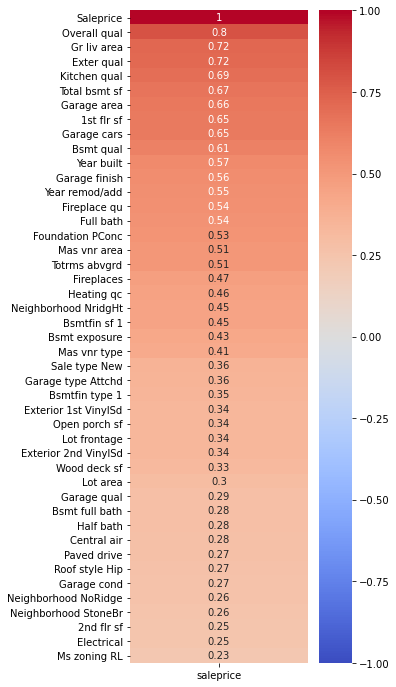

In [10]:
#no log mod, discrete scales original
plt.figure(figsize=(4,12))
sp_corr2= training_nologs.corr()[['saleprice']].sort_values('saleprice', ascending=False).head(45)
sns.heatmap(sp_corr2, cmap = 'coolwarm', annot=True, vmin=-1, vmax=1, yticklabels=[convert_snake_case(i) for i in sp_corr2.index]);

In [19]:
fullcorr_nologs = training_nologs.corr()[['saleprice']].sort_values('saleprice', ascending=False)
fullcorr_nologs.reset_index(inplace=True)

In [21]:
fullcorr_nologs.rename(columns={'index':'feature','saleprice':'corr_no_mods'},inplace=True)

In [26]:
fullcorr_logged.rename(columns={'index':'feature','saleprice':'corr_log_stretch'},inplace=True)

In [29]:
lasso_coefs.rename(columns={'Unnamed: 0':'feature', '0':'lasso_coef'}, inplace=True)

,feature,lasso_coef


In [40]:
#join and concat are on strike...merge works in two steps?  Scab.
corr_and_coef = fullcorr_nologs.merge(fullcorr_logged, on = 'feature')
corr_and_coef = corr_and_coef.merge(lasso_coefs, on = 'feature')


In [42]:
corr_and_coef.to_csv('./datasets/corr_and_coef_presentation.csv')